In [12]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import differential_evolution
import warnings
warnings.filterwarnings('ignore')

In [13]:
def fit_best_distribution(data, distributions=None, bins=50, plot=True):
    """
    Find the best-fitting probability distribution for empirical data.
    
    Parameters:
    -----------
    data : array-like
        The empirical dataset to fit
    distributions : list, optional
        List of scipy.stats distribution names to test. If None, uses common distributions.
    bins : int, default=50
        Number of histogram bins for plotting
    plot : bool, default=True
        Whether to plot results
        
    Returns:
    --------
    dict : Dictionary containing:
        - 'best_distribution': Name of best-fitting distribution
        - 'best_params': Parameters of best-fitting distribution
        - 'best_sse': Sum of squared errors for best fit
        - 'results': DataFrame with all tested distributions and their metrics
        - 'fitted_data': Data generated from best-fitting distribution
    """

    # Convert to numpy array and remove NaN values
    data = np.array(data)
    data = data[~np.isnan(data)]

    if len(data) == 0:
        raise ValueError("No valid data points after removing NaN values")

    # Default distributions to test if none provided
    if distributions is None:
        distributions = [
            stats.norm, stats.lognorm, stats.expon, stats.gamma, stats.beta,
            stats.weibull_min, stats.weibull_max, stats.chi2, stats.uniform,
            stats.pareto, stats.genextreme, stats.t, stats.logistic,
            stats.laplace, stats.gumbel_r, stats.gumbel_l
        ]

    # Convert string names to distribution objects if needed
    if isinstance(distributions[0], str):
        distributions = [getattr(stats, dist) for dist in distributions]

    # Calculate histogram for comparison
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    results = []

    for distribution in distributions:
        try:
            # Fit distribution parameters
            params = distribution.fit(data)

            # Calculate fitted distribution values at bin centers
            fitted_values = distribution.pdf(bin_centers, *params)

            # Calculate sum of squared errors
            sse = np.sum((hist - fitted_values) ** 2)

            # Calculate other goodness-of-fit metrics
            ks_stat, ks_p = stats.kstest(data, lambda x: distribution.cdf(x, *params))

            results.append({
                'distribution': distribution.name,
                'sse': sse,
                'ks_statistic': ks_stat,
                'ks_p_value': ks_p,
                'params': params,
                'distribution_obj': distribution
            })

        except Exception as e:
            # Skip distributions that fail to fit
            continue

    if not results:
        raise ValueError("No distributions could be fitted to the data")

    # Convert results to DataFrame and sort by SSE
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('sse').reset_index(drop=True)

    # Get best distribution
    best_result = results_df.iloc[0]
    best_distribution = best_result['distribution_obj']
    best_params = best_result['params']

    # Generate fitted data for plotting
    x_range = np.linspace(data.min(), data.max(), 1000)
    fitted_data = best_distribution.pdf(x_range, *best_params)

    # Plot results if requested
    if plot:
        plt.figure(figsize=(12, 8))

        # Plot histogram of original data
        plt.hist(data, bins=bins, density=True, alpha=0.7, color='lightblue',
                label='Empirical Data', edgecolor='black')

        # Plot best fitting distribution
        plt.plot(x_range, fitted_data, 'r-', linewidth=2,
                label=f'Best Fit: {best_result["distribution"]}')

        # Plot top 3 distributions
        colors = ['orange', 'green', 'purple']
        for i in range(min(3, len(results_df))):
            if i == 0:  # Skip best distribution (already plotted)
                continue
            result = results_df.iloc[i]
            dist_obj = result['distribution_obj']
            params = result['params']
            fitted_vals = dist_obj.pdf(x_range, *params)
            plt.plot(x_range, fitted_vals, '--', color=colors[i-1],
                    label=f'{result["distribution"]} (SSE: {result["sse"]:.4f})')

        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.title('Distribution Fitting Results')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Print summary
        print(f"Best fitting distribution: {best_result['distribution']}")
        print(f"Parameters: {best_params}")
        print(f"Sum of Squared Errors: {best_result['sse']:.6f}")
        print(f"Kolmogorov-Smirnov p-value: {best_result['ks_p_value']:.6f}")

    return {
        'best_distribution': best_result['distribution'],
        'best_params': best_params,
        'best_sse': best_result['sse'],
        'results': results_df[['distribution', 'sse', 'ks_statistic', 'ks_p_value']],
        'fitted_data': (x_range, fitted_data),
        'distribution_object': best_distribution
    }

Sample dataset 'cd' created with 1200 data points
Data range: -3.241 to 14.536
Mean: 1.953, Std: 2.757

FITTING DISTRIBUTIONS TO SAMPLE DATA


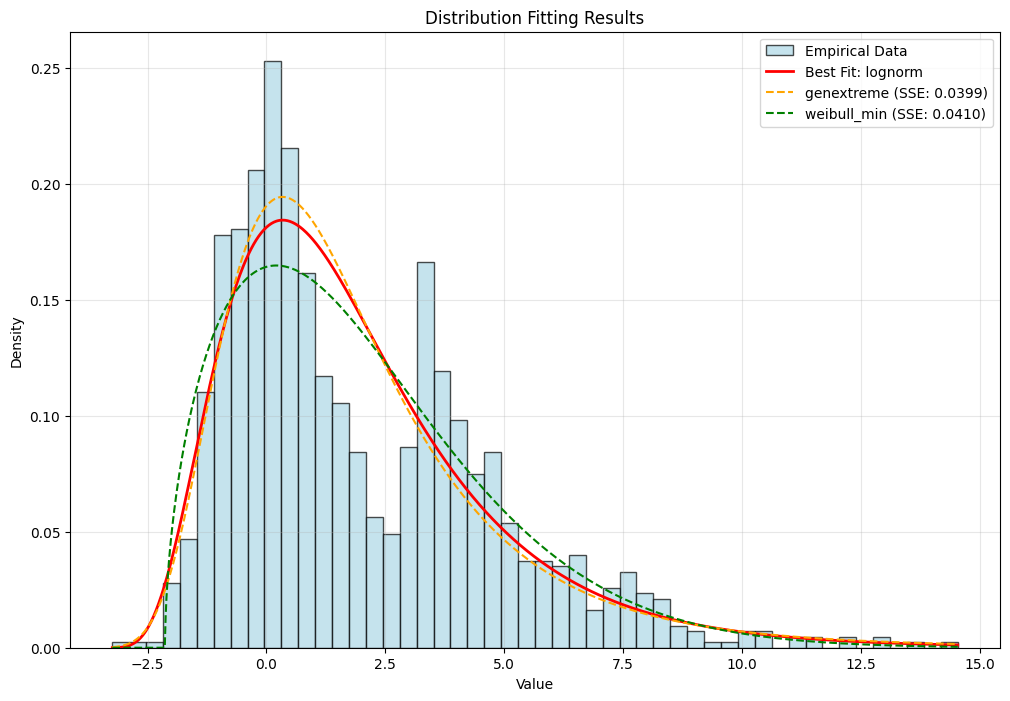

Best fitting distribution: lognorm
Parameters: (np.float64(0.46953570214569806), np.float64(-3.7838416691839383), np.float64(5.141870247624709))
Sum of Squared Errors: 0.039479
Kolmogorov-Smirnov p-value: 0.000002

Top 5 best-fitting distributions:
  distribution       sse  ks_statistic    ks_p_value
0      lognorm  0.039479      0.075119  2.462541e-06
1   genextreme  0.039910      0.086409  3.033635e-08
2  weibull_min  0.040996      0.067243  3.670748e-05
3         beta  0.046975      0.079198  5.399984e-07
4         chi2  0.047151      0.079570  4.684397e-07


In [14]:
# Create sample dataset for testing
np.random.seed(42)

# Generate mixed sample data with known distributions for testing
normal_data = np.random.normal(0, 1, 500)
exponential_data = np.random.exponential(2, 300)
gamma_data = np.random.gamma(2, 2, 400)

# Combine for a more complex distribution
cd = np.concatenate([normal_data, exponential_data + 3, gamma_data - 2])

print(f"Sample dataset 'cd' created with {len(cd)} data points")
print(f"Data range: {cd.min():.3f} to {cd.max():.3f}")
print(f"Mean: {cd.mean():.3f}, Std: {cd.std():.3f}")

# Example usage of the fitting function
print("\n" + "="*50)
print("FITTING DISTRIBUTIONS TO SAMPLE DATA")
print("="*50)

result = fit_best_distribution(cd)

print(f"\nTop 5 best-fitting distributions:")
print(result['results'].head())

In [21]:
cd = pd.read_clipboard()

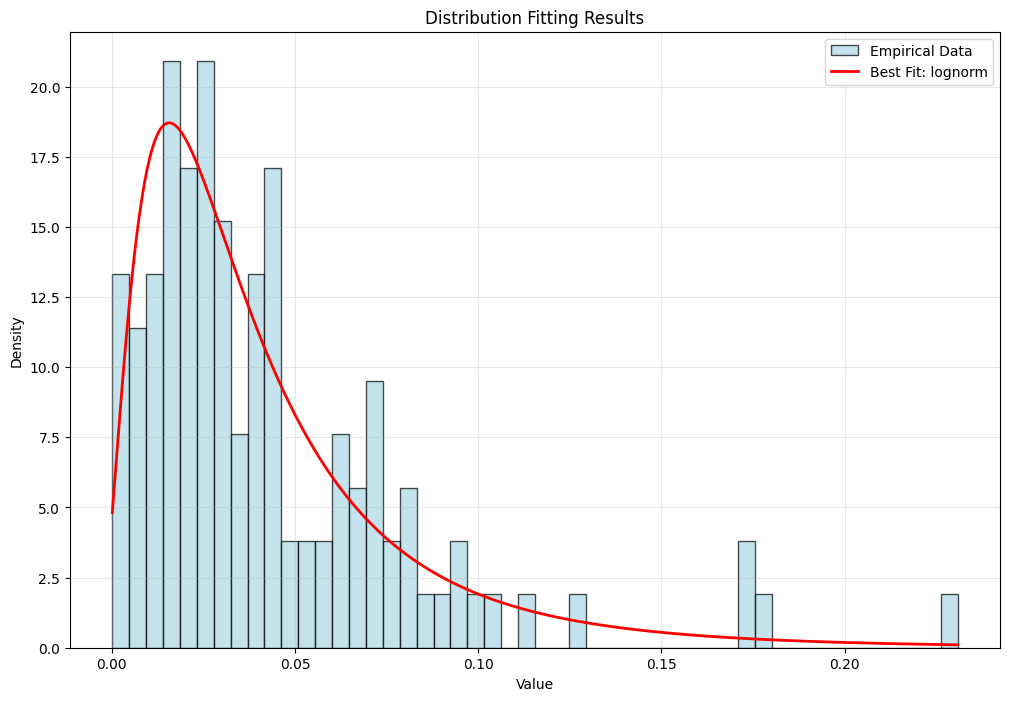

Best fitting distribution: lognorm
Parameters: (np.float64(0.7368404047063558), -0.006416241386700143, np.float64(0.03796451847033262))
Sum of Squared Errors: 279.516889
Kolmogorov-Smirnov p-value: 0.993624

Top 5 best-fitting distributions:
  distribution         sse  ks_statistic  ks_p_value
0      lognorm  279.516889       0.03847    0.993624


In [23]:
result = fit_best_distribution(cd, distributions=[stats.lognorm])

print(f"\nTop 5 best-fitting distributions:")
print(result['results'].head())

In [25]:
def generate_custom_number():
    """
    Generate a random number based on specific probability rules:
    - 68% chance positive (lognormal distribution)
    - 32% chance negative (uniform distribution)
    
    Returns:
    --------
    float : Random number following the specified distribution
    """
    
    # Step 1: Determine if positive or negative (68% vs 32%)
    if np.random.random() < 0.68:
        # Step 3: Positive - lognormal distribution
        # mu = -3.2711 (already logged), sigma = 0.73684
        return min(np.random.lognormal(mean=-3.2711, sigma=0.73684),0.15)
    else:
        # Step 2: Negative - uniform distribution from 0 to -0.1
        return np.random.uniform(low=-0.09, high=0.0)

# Test the function with multiple samples
print("Testing custom number generator:")
print("="*40)

samples = [generate_custom_number() for _ in range(10)]
positive_count = sum(1 for x in samples if x > 0)
negative_count = len(samples) - positive_count

print(f"Sample of 10 numbers: {[f'{x:.4f}' for x in samples]}")
print(f"Positive: {positive_count}/10, Negative: {negative_count}/10")

# Generate larger sample to verify distribution
large_sample = [generate_custom_number() for _ in range(10000)]
pos_pct = sum(1 for x in large_sample if x > 0) / len(large_sample) * 100
neg_pct = 100 - pos_pct

print(f"\nLarge sample (n=10,000):")
print(f"Positive: {pos_pct:.1f}% (target: 68%)")
print(f"Negative: {neg_pct:.1f}% (target: 32%)")

# Analyze the distributions
positive_values = [x for x in large_sample if x > 0]
negative_values = [x for x in large_sample if x < 0]

print(f"\nPositive values stats:")
print(f"  Count: {len(positive_values)}")
print(f"  Mean: {np.mean(positive_values):.4f}")
print(f"  Std: {np.std(positive_values):.4f}")

print(f"\nNegative values stats:")
print(f"  Count: {len(negative_values)}")
print(f"  Range: [{min(negative_values):.4f}, {max(negative_values):.4f}]")
print(f"  Mean: {np.mean(negative_values):.4f}")

Testing custom number generator:
Sample of 10 numbers: ['0.0210', '0.0216', '-0.0127', '0.0214', '-0.0594', '0.0809', '0.0117', '0.0674', '0.0179', '0.1488']
Positive: 8/10, Negative: 2/10

Large sample (n=10,000):
Positive: 68.8% (target: 68%)
Negative: 31.2% (target: 32%)

Positive values stats:
  Count: 6878
  Mean: 0.0485
  Std: 0.0347

Negative values stats:
  Count: 3122
  Range: [-0.0900, -0.0000]
  Mean: -0.0458
